In [2]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt
import funciones
import parametros
import csv

# Mapa

In [3]:
north = -41.4
south = -41.496
east = -72.8
west = -73.03

PM = ox.graph_from_bbox(north,south,east,west,network_type='drive')

In [4]:
duplicados = []

for u,v,a in PM.edges(data = True):
  if len(PM[u][v]) == 2:
    duplicados.append((u,v,1))
  elif len(PM[u][v]) == 3:
    duplicados.append((u,v,1))
    duplicados.append((u,v,2))


duplicados = list(dict.fromkeys(duplicados))
PM.remove_edges_from(duplicados)

In [5]:
def setear(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Omitir el encabezado, si existe
        coordenadas = [tuple(map(float, row[1:3])) for row in reader]
    return coordenadas

In [6]:
coordenadas_plantas = setear('datos/ubicacion_produccion.csv')
coordenadas_almacenes = setear('datos/ubicacion_demanda.csv')
coordenadas_bodegas = setear('datos/ubicacion_bodegas_adicionales.csv')

print (coordenadas_plantas)
print(coordenadas_almacenes)
print(coordenadas_bodegas)

[(-72.9049847, -41.4382097), (-72.89773, -41.4616118), (-73.0018052, -41.4748112), (-72.9806647, -41.4723745), (-72.9569328, -41.4269752), (-72.886137, -41.4280949), (-72.9125495, -41.4548131)]
[(-72.9180463, -41.4723684), (-72.9469427, -41.4568804), (-72.9942386, -41.4478807), (-72.9723534, -41.4658041), (-72.9047511, -41.4556736), (-72.989895, -41.478831), (-72.9365376, -41.465138), (-72.9793107, -41.470842), (-72.9192027, -41.4598745), (-72.9708642, -41.4873284), (-72.9229513, -41.4737758), (-72.9237241, -41.4616888), (-72.9144487, -41.4744047), (-72.9690185, -41.4795911), (-72.9703678, -41.4669273), (-72.9420883, -41.4560195), (-72.9723474, -41.4671811), (-72.9100943, -41.4596985), (-72.9988203, -41.4658013), (-72.9911929, -41.4441747), (-72.9113151, -41.4222032), (-72.9172653, -41.4616971), (-72.9911983, -41.4790814), (-72.9037715, -41.4110034)]
[(-72.995677, -41.4626411), (-72.9575967, -41.4735434), (-72.9709703, -41.46606), (-72.9214348, -41.4473181), (-72.9017258, -41.4044988),

In [7]:
def buscar_nodo(grafo, lista_coords):
    nodos = []
    for ubicacion in lista_coords:
        x = ubicacion[0]
        y = ubicacion[1]
        print(f"Buscando nodo cercano para la coordenada: x = {x}, y = {y}")
        nodo_cercano = ox.nearest_nodes(grafo, x, y)
        nodos.append(nodo_cercano)
    return nodos

In [8]:
n_plantas = buscar_nodo(PM, coordenadas_plantas)
n_almacenes = buscar_nodo(PM, coordenadas_almacenes)
n_bodegas = buscar_nodo(PM, coordenadas_bodegas)

print("Nodos plantas:", n_plantas)
print("Nodos almacenes:", n_almacenes)
print("Nodos bodegas:", n_bodegas)

Buscando nodo cercano para la coordenada: x = -72.9049847, y = -41.4382097
Buscando nodo cercano para la coordenada: x = -72.89773, y = -41.4616118
Buscando nodo cercano para la coordenada: x = -73.0018052, y = -41.4748112
Buscando nodo cercano para la coordenada: x = -72.9806647, y = -41.4723745
Buscando nodo cercano para la coordenada: x = -72.9569328, y = -41.4269752
Buscando nodo cercano para la coordenada: x = -72.886137, y = -41.4280949
Buscando nodo cercano para la coordenada: x = -72.9125495, y = -41.4548131
Buscando nodo cercano para la coordenada: x = -72.9180463, y = -41.4723684
Buscando nodo cercano para la coordenada: x = -72.9469427, y = -41.4568804
Buscando nodo cercano para la coordenada: x = -72.9942386, y = -41.4478807
Buscando nodo cercano para la coordenada: x = -72.9723534, y = -41.4658041
Buscando nodo cercano para la coordenada: x = -72.9047511, y = -41.4556736
Buscando nodo cercano para la coordenada: x = -72.989895, y = -41.478831
Buscando nodo cercano para la 

In [9]:
plantas = []

for i in range(len(n_plantas)):
  plantas.append('planta' + str(i+1))


almacenes = []

for i in range(len(n_almacenes)):
  almacenes.append('almacén' + str(i+1))


bodegas = []

for i in range(len(n_bodegas)):
  bodegas.append('bodega' + str(i+1))



In [10]:
for node_id, nuevo_nombre in zip(n_plantas, plantas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de planta no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_almacenes, almacenes):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de almacén no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_bodegas, bodegas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de bodega no encontrado en el grafo")

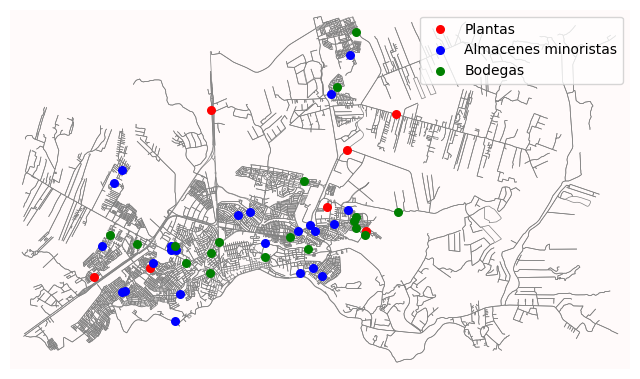

In [11]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(PM, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor = 'snow', close=False, show=False)


ax.scatter([PM.nodes[node]['x'] for node in n_plantas],
           [PM.nodes[node]['y'] for node in n_plantas],
           c='red', s=30, label="Plantas")

ax.scatter([PM.nodes[node]['x'] for node in n_almacenes],
           [PM.nodes[node]['y'] for node in n_almacenes],
           c='blue', s=30, label="Almacenes minoristas")

ax.scatter([PM.nodes[node]['x'] for node in n_bodegas],
           [PM.nodes[node]['y'] for node in n_bodegas],
           c='green', s=30, label="Bodegas")

plt.legend(loc="upper right")
plt.show()

# Parte 0: Procesamiento

In [12]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo = funciones.Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,parametros.P+1):
    nombres.append(f'PB{a}')

In [13]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega  a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [14]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min = funciones.rutas_min(grafo_vial_nuevo, parametros.G, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [15]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [16]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

In [17]:
I = parametros.P
J = parametros.B + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_bodegas.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_bodega = pd.DataFrame(data = dict_matriz)


prod_bodega['id'] = list(nodos_produccion.index)

prod_bodega = prod_bodega.set_index('id')

for i in range(len(matriz_costos_prod_bod)):
    fila = matriz_costos_prod_bod.loc[i]['origen']
    columna = matriz_costos_prod_bod.loc[i]['destino']
    guardar = matriz_costos_prod_bod.loc[i]['distancia']
    prod_bodega.loc[fila][columna] = guardar

In [18]:
I = parametros.P
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_demanda = pd.DataFrame(data = dict_matriz)


prod_demanda['id'] = list(nodos_produccion.index)

prod_demanda = prod_demanda.set_index('id')

for i in range(len(matriz_costos_prod_dem)):
    fila = matriz_costos_prod_dem.loc[i]['origen']
    columna = matriz_costos_prod_dem.loc[i]['destino']
    guardar = matriz_costos_prod_dem.loc[i]['distancia']
    prod_demanda.loc[fila][columna] = guardar


In [19]:
I = parametros.B
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

bod_demanda = pd.DataFrame(data = dict_matriz)


bod_demanda['id'] = list(nodos_bodegas.index)

bod_demanda = bod_demanda.set_index('id')

for i in range(len(matriz_costos_bod_dem)):
    fila = matriz_costos_bod_dem.loc[i]['origen']
    columna = matriz_costos_bod_dem.loc[i]['destino']
    guardar = matriz_costos_bod_dem.loc[i]['distancia']
    bod_demanda.loc[fila][columna] = guardar

In [20]:
prod_demanda_distancias = prod_demanda
prod_demanda = round((prod_demanda / 1000) * 12)

prod_bodega_distancias = prod_bodega
prod_bodega = round((prod_bodega / 1000) * 12)

bod_demanda_distancias = bod_demanda
bod_demanda = round((bod_demanda / 1000) * 12)

# Parte I

## armo grafo

In [21]:
G1 = nx.DiGraph()

### Nodos

In [22]:
#se agregan los nodos correspondientes a las tiendas

entra = 0
sale = 0

for d in range(1, parametros.D+1):
  for t in range(1, parametros.T+1):
    nombre_nodo = 'D' + str(d) + ', t' + str(t)
    demanda = (demanda_max.loc[f'D{d}'][f'{t}'] - demanda_min.loc[f'D{d}'][f'{t}'])
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

In [23]:
#se agregan los nodos correspondientes a las fábricas

for p in range(1, parametros.P+1):
  for t in range(1, parametros.T):
    nombre_nodo = 'P' + str(p) + ', t' + str(t)
    oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
    entra += oferta
    G1.add_node(nombre_nodo, demand = -oferta)

In [24]:
inv_inicial_fabricas = inventario_inicial.to_dict()['1']
inv_inicial_bodegas = inventario_inicial_adicional.to_dict()['1']

In [25]:
#se agregan los nodos correspondientes a las bodegas de las fábricas

inv_0_fabricas = 0

for i in range(1, parametros.P + 1):
  for j in range(1, parametros.T + 1):
    nombre_nodo = 'P_bodega' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_fabricas[f'P{i}']
      inv_0_fabricas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [26]:
#se agregan los nodos de bodegas adicionales
inv_0_bodegas = 0

for i in range(1, parametros.B+1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_bodegas[f'B{i}']
      inv_0_bodegas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [27]:
#se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como adicionales

for p in range(1, parametros.P + 1):
  for j in range(1, parametros.T +1):
    nombre_nodo = 'P_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

for i in range(1, parametros.B + 1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

In [28]:
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

-24096


In [29]:
G1.add_node('Sumidero', demand = -suma)

In [30]:
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

0


### Arcos

In [31]:
#se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

for t in range(1, parametros.T):
  for i in range(1, parametros.P + 1):
      nombrefab = 'P' + str(i) + ', t' + str(t)
      nombreaux = 'P_aux' + str(i) + ', t' + str(t)
      costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
      G1.add_edge(nombrefab, nombreaux, weight = costo_prod)


In [32]:
#se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

for t in range(1, parametros.T + 1):
  for b in range(1, parametros.P + 1):
    for s in range(1, parametros.D +1):
      costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      G1.add_edge(nombrebod, nombretienda, weight = costo_trans)

In [33]:
#agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P+1):
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    G1.add_edge(nombrebod, nombreaux, weight = 0)

In [34]:
#agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
#en el periodo siguiente

for t in range(1, parametros.T):
  for b in range(1, parametros.P + 1):
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
    G1.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)

In [35]:
#agregamos arcos desde bodegas de fabricas hasta auxiliares de bodegas adicionales del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P +1):
    for a in range(1, parametros.B + 1):
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
      costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
      G1.add_edge(nombrebod, nombreauxad, weight = costo_trans)

In [36]:
#agregamos arcos  desde nodos auxiliares de bodegas adicionales hasta la misma bodega en el siguiente periodo, para
#todos los periodos y todas las bodegas

for t in range(1, parametros.T):
  for a in range(1, parametros.B + 1):
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    nombrebodad = 'B' + str(a) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    G1.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

In [37]:
#agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

for t in range(1, parametros.T+1):
  for a in range(1, parametros.B +1 ):
    nombrebodad = 'B' + str(a) + ', t' + str(t)
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    G1.add_edge(nombrebodad, nombreauxad, weight = 0)

In [38]:
#agregamos arcos que unen las bodegas adicionales con las tiendas para todos los periodos

for t in range(1, parametros.T +1):
  for s in range(1, parametros.D +1):
    for a in range(1, parametros.B +1):
      nombrebodad = 'B' + str(a) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']
      G1.add_edge(nombrebodad, nombretienda, weight = costo_trans)

In [39]:
#agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 0)

In [40]:
'''#agregamos arcos desde bodegas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.B + 1):
    nombrefab = 'B_aux' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000000000)'''

"#agregamos arcos desde bodegas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta\n\nfor t in range(1, parametros.T + 1):\n  for f in range(1, parametros.B + 1):\n    nombrefab = 'B_aux' + str(f) + ', t' + str(t)\n    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000000000)"

In [41]:
'''#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P_aux' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)'''

"#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta\n\nfor t in range(1, parametros.T + 1):\n  for f in range(1, parametros.P + 1):\n    nombrefab = 'P_aux' + str(f) + ', t' + str(t)\n    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)"

In [42]:
'''#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P_bodega' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)'''

"#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta\n\nfor t in range(1, parametros.T + 1):\n  for f in range(1, parametros.P + 1):\n    nombrefab = 'P_bodega' + str(f) + ', t' + str(t)\n    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)"

In [43]:
#agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

for t in range(1, parametros.T+1):
  for s in range(1, parametros.D+1):
    costo_dda_no = 1000
    nombretienda = 'D' + str(s) + ', t' + str(t)
    G1.add_edge('Sumidero', nombretienda, weight = costo_dda_no)

### sol

In [44]:
sol = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

# Parte II

In [45]:
# Lista con todos los nodos (nombre) y los periodos de tiempo en formato 't...'
bodegas = list(nodos_bodegas.index)
fabricas = list(nodos_produccion.index)
tiendas = list(nodos_demanda.index)

dias = []
for t in range(1, parametros.T+1):
  dias.append('t' + str(t))

fabricas_bodegas = []
fabricas_aux = []
for i in range(1, parametros.P + 1):
  fabricas_bodegas.append('P_bodega' + str(i))
  fabricas_aux.append('P_aux' + str(i))

bodegas_aux = []
for i in range(1, parametros.B + 1):
  fabricas_bodegas.append('B_aux' + str(i))

### Funciones

#### funcion 1

Construcción de una función que reciba como argumentos un periodo de tiempo, y que 
entregue un gráfico que muestre las plantas, bodegas y minoristas, y que ilustre las rutas 
y cargas transportadas entre estos nodos. Si además esta gráfica muestra niveles de 
inventario inicial y final en cada nodo, el grupo recibirá una bonificación.

#### funcion 2

Construir una función que reciba como argumentos una bodega, y que entregue la 
evolución de su nivel de inventario. Esta función también debe permitir hacer este 
análisis en forma agregada para el sistema (es decir, sumado para todas las bodegas)

In [46]:
# con un poco de trabajo se puede hacer a partir de la funcion 3

#### funcion 3

Construir  una  función  que  construya  un  reporte  de  operación  diaria,  que  indique 
claramente el plan operativo del día, en un formato que podría ser fácilmente entendido 
por el personal responsable de ejecutar las instrucciones.

In [51]:
def imprimir_programacion(num_dia: int):
    if num_dia > 8:
        print('Día fuera del periodo productivo.')

    elif num_dia == 8:
        dia_actual = dias[num_dia-1]
        día_siguiente = dia_actual

    else:
        dia_actual = dias[num_dia-1]
        dia_siguiente = dias[num_dia]

    sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

    for nodo_origen in list(sol.keys()):
        if dia_actual in nodo_origen:
            if len(sol[nodo_origen]) != 0:
                sol_1[nodo_origen] = sol[nodo_origen]

    sol_2 = {}
    for nodo_origen in list(sol_1.keys()):
        sol_2[nodo_origen] = {}
        for nodo_destino in sol_1[nodo_origen]:
            if sol_1[nodo_origen][nodo_destino] != 0:
                sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

    # imprimo el tipo de nodo de origen desde el que envio

    for nodo_origen in (list(sol_2.keys())):
        if 'P_aux' not in nodo_origen and 'P_bod' not in nodo_origen and 'P' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'P_aux' in nodo_destino:
                    que_nodo = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo} produce {cantidad} dulces.')

        if 'P_bodega' in nodo_origen:        
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                cantidad = sol_2[nodo_origen][nodo_destino]
                if 'D' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la casa {que_nodo_destino}.')
                
                if 'B' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la bodega {que_nodo_destino}.')
        
        if 'P_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):            
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} guarda {cantidad} dulces para el dia siguiente en la bodega {que_nodo_destino}.')
        
        if 'B' in nodo_origen and 'B_aux' not in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'D' in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la casa {que_nodo_destino}.')
        
        if 'B_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día siguiente.')

In [52]:
imprimir_programacion(1)

Fábrica 1 produce 1081 dulces.
Fábrica 2 produce 36 dulces.
Fábrica 3 produce 1200 dulces.
Fábrica 4 produce 738 dulces.
Fábrica 5 produce 1303 dulces.
Fábrica 6 produce 1949 dulces.
Fábrica 7 produce 833 dulces.
Fábrica 1 envia 119 dulces a la casa 5.
Fábrica 1 envia 204 dulces a la casa 9.
Fábrica 1 envia 178 dulces a la casa 12.
Fábrica 2 envia 174 dulces a la casa 1.
Fábrica 2 envia 116 dulces a la casa 13.
Fábrica 2 envia 15 dulces a la casa 18.
Fábrica 3 envia 253 dulces a la casa 8.
Fábrica 3 envia 246 dulces a la casa 19.
Fábrica 4 envia 51 dulces a la casa 8.
Fábrica 5 envia 196 dulces a la casa 2.
Fábrica 5 envia 304 dulces a la casa 16.
Fábrica 6 envia 151 dulces a la casa 21.
Fábrica 6 envia 153 dulces a la casa 24.
Fábrica 7 envia 301 dulces a la casa 22.
Fábrica 1 envia 46 dulces a la casa 3.
Fábrica 1 envia 54 dulces a la casa 19.
Fábrica 2 envia 20 dulces a la casa 14.
Fábrica 4 envia 22 dulces a la casa 12.
Fábrica 5 envia 100 dulces a la casa 24.
Fábrica 6 envia 36 du

### otros

In [49]:
# me dice la demanda q el sumidero esta supliendo
for a in sol['Sumidero'].keys():
    if sol['Sumidero'][a] !=0:
        print(a,sol['Sumidero'][a])

D2, t1 104
D3, t1 254
D4, t1 304
D6, t1 400
D7, t1 270
D10, t1 305
D11, t1 304
D13, t1 64
D14, t1 226
D15, t1 206
D17, t1 161
D20, t1 201
D23, t1 200
D24, t1 47


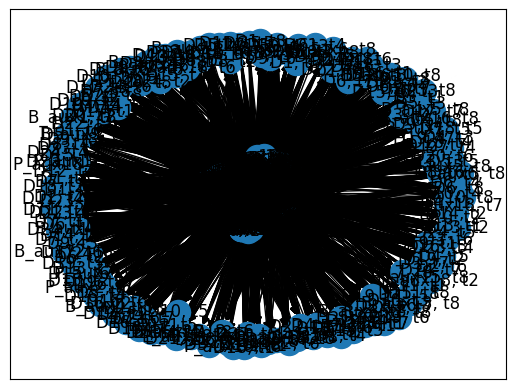

In [50]:
nx.draw_networkx(G1)